In [1]:
import torch
from torch import nn, optim
from datetime import datetime
import os
import wandb
from pathlib import Path

In [2]:
from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)

def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
            s=sign,
            D="{:d}".format(int(days)),
            H="{:02d}".format(int(hours)),
            M="{:02d}".format(int(mins)),
            S="{:02d}".format(int(secs)),
        )

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=10, delta=0.0001, project_name=None, checkpoint_file_path=None, run_time_str=None):
        self.patience = patience
        self.counter = 0
        self.delta = delta

        self.val_loss_min = None
        self.file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
        )
        self.latest_file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
        )

    def check_and_save(self, new_validation_loss, model):
        early_stop = False

        if self.val_loss_min is None:
            self.val_loss_min = new_validation_loss
            message = f'Early stopping is stated!'
        elif new_validation_loss < self.val_loss_min - self.delta:
            message = f'V_loss decreased ({self.val_loss_min:6.3f} --> {new_validation_loss:6.3f}). Saving model...'
            self.save_checkpoint(new_validation_loss, model)
            self.val_loss_min = new_validation_loss
            self.counter = 0
        else:
            self.counter += 1
            message = f'Early stopping counter: {self.counter} out of {self.patience}'
            if self.counter >= self.patience:
                early_stop = True
                message += " *** TRAIN EARLY STOPPED! ***"

        return message, early_stop
    
    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.file_path)
        torch.save(model.state_dict(), self.latest_file_path)
        self.val_loss_min = val_loss

In [4]:
class ClassificationTrainer:
    def __init__(
        self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
        run_time_str, wandb, device, checkpoint_file_path
    ):
        self.project_name = project_name
        self.model = model
        self.optimizer = optimizer
        self.train_data_loader = train_data_loader
        self.validation_data_loader = validation_data_loader
        self.transforms = transforms
        self.run_time_str = run_time_str
        self.wandb = wandb
        self.device = device
        self.checkpoint_file_path = checkpoint_file_path

        # Use a built-in loss function
        self.loss_fn = nn.CrossEntropyLoss()

    def do_train(self):
        self.model.train()  # Explained at 'Diverse Techniques' section

        loss_train = 0.0
        num_corrects_train = 0
        num_trained_samples = 0
        num_trains = 0

        for train_batch in self.train_data_loader:
            input_train, target_train = train_batch
            input_train = input_train.to(device=self.device)
            target_train = target_train.to(device=self.device)

            input_train = self.transforms(input_train)

            output_train = self.model(input_train)
            loss = self.loss_fn(output_train, target_train)
            loss_train += loss.item()

            predicted_train = torch.argmax(output_train, dim=1)
            num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

            num_trained_samples += len(input_train)
            num_trains += 1

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        train_loss = loss_train / num_trains
        train_accuracy = 100.0 * num_corrects_train / num_trained_samples

        return train_loss, train_accuracy

    def do_validation(self):
        self.model.eval()   # Explained at 'Diverse Techniques' section

        loss_validation = 0.0
        num_corrects_validation = 0
        num_validated_samples = 0
        num_validations = 0

        with torch.no_grad():
            for validation_batch in self.validation_data_loader:
                input_validation, target_validation = validation_batch
                input_validation = input_validation.to(device=self.device)
                target_validation = target_validation.to(device=self.device)

                input_validation = self.transforms(input_validation)

                output_validation = self.model(input_validation)
                loss_validation += self.loss_fn(output_validation, target_validation).item()

                predicted_validation = torch.argmax(output_validation, dim=1)
                num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

                num_validated_samples += len(input_validation)
                num_validations += 1

        validation_loss = loss_validation / num_validations
        validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

        return validation_loss, validation_accuracy

    def train_loop(self):
        early_stopping = EarlyStopping(
        patience=self.wandb.config.early_stop_patience,
        project_name=self.project_name,
        checkpoint_file_path=self.checkpoint_file_path,
        run_time_str=self.run_time_str
        )
        n_epochs = self.wandb.config.epochs
        training_start_time = datetime.now()

        for epoch in range(1, n_epochs + 1):
            train_loss, train_accuracy = self.do_train()

            if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
                validation_loss, validation_accuracy = self.do_validation()

                elapsed_time = datetime.now() - training_start_time
                epoch_per_second = epoch / elapsed_time.seconds

                message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

                print(
                    f"[Epoch {epoch:>3}] "
                    f"T_loss: {train_loss:6.4f}, "
                    f"T_accuracy: {train_accuracy:6.4f} | "
                    f"V_loss: {validation_loss:6.4f}, "
                    f"V_accuracy: {validation_accuracy:6.4f} | "
                    f"{message} | "
                    f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
                    f"T_speed: {epoch_per_second:4.3f}"
                )

                self.wandb.log({
                    "Epoch": epoch,
                    "Training loss": train_loss,
                    "Training accuracy (%)": train_accuracy,
                    "Validation loss": validation_loss,
                    "Validation accuracy (%)": validation_accuracy,
                    "Training speed (epochs/sec.)": epoch_per_second,
                })

                if early_stop:
                    break

        elapsed_time = datetime.now() - training_start_time
        print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")


In [5]:
class ClassificationTester:
    def __init__(self, project_name, model, test_data_loader, transforms, checkpoint_file_path):
        self.project_name = project_name
        self.model = model
        self.test_data_loader = test_data_loader
        self.transforms = transforms

        self.latest_file_path = os.path.join(
            checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
        )

        print("MODEL FILE: {0}".format(self.latest_file_path))

        self.model.load_state_dict(torch.load(self.latest_file_path, map_location=torch.device('cpu')))

    def test(self):
        self.model.eval()    # Explained at 'Diverse Techniques' section

        num_corrects_test = 0
        num_tested_samples = 0

        with torch.no_grad():
            for test_batch in self.test_data_loader:
                input_test, target_test = test_batch

                input_test = self.transforms(input_test)

                output_test = self.model(input_test)

                predicted_test = torch.argmax(output_test, dim=1)
                num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

                num_tested_samples += len(input_test)

            test_accuracy = 100.0 * num_corrects_test / num_tested_samples

        print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    def test_single(self, input_test):
        self.model.eval()    # Explained at 'Diverse Techniques' section

        with torch.no_grad():
            input_test = self.transforms(input_test)

            output_test = self.model(input_test)
            predicted_test = torch.argmax(output_test, dim=1)

        return predicted_test.item()

In [6]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from datetime import datetime
import os
import wandb
from pathlib import Path

CHECKPOINT_FILE_PATH = "./Mnist_Output"

In [64]:
def get_mnist_data(flatten=False):
    data_path = "../Data/h_h_mnist"

    mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
    mnist_train, mnist_validation = random_split(mnist_train, [55_000, 5_000])

    print("Num Train Samples: ", len(mnist_train))
    print("Num Validation Samples: ", len(mnist_validation))

    #num_data_loading_workers = os.cpu_count() or 1
    num_data_loading_workers = 1
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=mnist_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=mnist_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.1307, std=0.3081),
    )

    if flatten:
        mnist_transforms.append(nn.Flatten())

    return train_data_loader, validation_data_loader, mnist_transforms

In [47]:
def get_cnn_model():
    class MyModel(nn.Module):
        def __init__(self, in_channels, n_output):
            super().__init__()

            self.model = nn.Sequential(
                # B x 1 x 28 x 28 --> B x 6 x (28 - 5 + 1) x (28 - 5 + 1) = B x 6 x 24 x 24
                nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
                # B x 6 x 24 x 24 --> B x 6 x 12 x 12
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.ReLU(),
                # B x 6 x 12 x 12 --> B x 16 x (12 - 5 + 1) x (12 - 5 + 1) = B x 16 x 8 x 8
                nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
                # B x 16 x 8 x 8 --> B x 16 x 4 x 4
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.ReLU(),
                nn.Flatten(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, n_output),
              )

        def forward(self, x):
            x = self.model(x)
            return x

    # 1 * 28 * 28
    my_model = MyModel(in_channels=1, n_output=10)

    return my_model

In [60]:
def main(args_wandb, args_epochs, args_batch_size, args_validation_intervals, args_learning_rate, args_early_stop_patience):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args_epochs,
        'batch_size': args_batch_size,
        'validation_intervals': args_validation_intervals,
        'learning_rate': args_learning_rate,
        'early_stop_patience': args_early_stop_patience
    }

    project_name = "cnn_mnist"
    wandb.init(
        mode="online" if args_wandb else "disabled",
        project=project_name,
        notes="mnist experiment with cnn",
        tags=["cnn", "mnist"],
        name=run_time_str,
        config=config
    )
    print(wandb.config)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    train_data_loader, validation_data_loader, mnist_transforms = get_mnist_data(flatten=False)
    model = get_cnn_model()
    model.to(device)
    wandb.watch(model)

    from torchinfo import summary
    summary(model=model, input_size=(1, 1, 28, 28))

    optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, mnist_transforms,
        run_time_str, wandb, device, CHECKPOINT_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

In [65]:
if __name__ == "__main__":
    #parser = get_parser()
    #args = parser.parse_args()
    args_wandb = True
    args_epochs = 200
    args_batch_size = 32
    args_validation_intervals = 10
    args_learning_rate = 0.001
    args_early_stop_patience = 10
    main(args_wandb, args_epochs, args_batch_size, args_validation_intervals, args_learning_rate, args_early_stop_patience)

Epoch,▁▄█
Training accuracy (%),▁██
Training loss,█▁▁
Training speed (epochs/sec.),▁▇█
Validation accuracy (%),▁██
Validation loss,█▁▁
Epoch,20
Training accuracy (%),97.44364
Training loss,0.08463
Training speed (epochs/sec.),0.07692
Validation accuracy (%),97.46


{'epochs': 200, 'batch_size': 32, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 10}
Training on device cpu.
Num Train Samples:  55000
Num Validation Samples:  5000
Number of Data Loading Workers: 1
[Epoch   1] T_loss: 2.2501, T_accuracy: 21.8509 | V_loss: 2.0942, V_accuracy: 52.7200 | Early stopping is stated! | T_time: 00:00:14, T_speed: 0.071
[Epoch  10] T_loss: 0.1458, T_accuracy: 95.8382 | V_loss: 0.1414, V_accuracy: 96.0200 | V_loss decreased ( 2.094 -->  0.141). Saving model... | T_time: 00:02:07, T_speed: 0.079
[Epoch  20] T_loss: 0.0876, T_accuracy: 97.4164 | V_loss: 0.0923, V_accuracy: 97.5000 | V_loss decreased ( 0.141 -->  0.092). Saving model... | T_time: 00:04:13, T_speed: 0.079
[Epoch  30] T_loss: 0.0653, T_accuracy: 98.0236 | V_loss: 0.0762, V_accuracy: 97.8600 | V_loss decreased ( 0.092 -->  0.076). Saving model... | T_time: 00:06:20, T_speed: 0.079
[Epoch  40] T_loss: 0.0523, T_accuracy: 98.4291 | V_loss: 0.0645, V_accuracy: 98.1600 | V_los

KeyboardInterrupt: 

In [50]:
import numpy as np
import torch
import os

from matplotlib import pyplot as plt
from torch import nn
from torchvision import transforms, datasets
from pathlib import Path

from torch.utils.data import DataLoader

In [51]:
def get_mnist_test_data(flatten=False):
    data_path = "../Data/h_mnist"

    mnist_test_images = datasets.MNIST(data_path, train=False, download=True)

    mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transforms.ToTensor())
    test_data_loader = DataLoader(dataset=mnist_test, batch_size=len(mnist_test))

    mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.1307, std=0.3081),
    )

    if flatten:
        mnist_transforms.append(
        nn.Flatten()
    )

    return mnist_test_images, test_data_loader, mnist_transforms

In [54]:
def main():
    mnist_test_images, test_data_loader, mnist_transforms = get_mnist_test_data(flatten=False)

    test_model = get_cnn_model()
    classification_tester = ClassificationTester(
        "cnn_mnist", test_model, test_data_loader, mnist_transforms, CHECKPOINT_FILE_PATH
    )
    classification_tester.test()

    print()

    img, label = mnist_test_images[0]
    print("     LABEL:", label)
    plt.imshow(img)
    plt.show()

    # torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0).shape: (1, 1, 28, 28)
    output = classification_tester.test_single(
        torch.tensor(np.array(mnist_test_images[0][0])).unsqueeze(dim=0).unsqueeze(dim=0)
    )
    print("PREDICTION:", output)

MODEL FILE: ./Mnist_Output/cnn_mnist_checkpoint_latest.pt
TEST RESULTS: 98.920%

     LABEL: 7


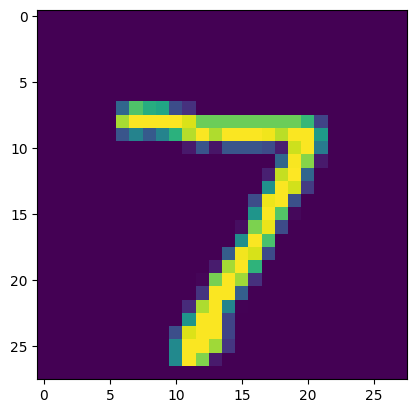

PREDICTION: 7


In [55]:
if __name__ == "__main__":
    main()

In [8]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from datetime import datetime
import os
import wandb
from pathlib import Path

In [9]:
def get_cifar10_data(flatten=False):
    data_path = "../Data/i_cifar10"

    print("DATA PATH: {0}".format(data_path))

    cifar10_train = datasets.CIFAR10(data_path, train=True, download=True, transform=transforms.ToTensor())

    cifar10_train, cifar10_validation = random_split(cifar10_train, [45_000, 5_000])

    print("Num Train Samples: ", len(cifar10_train))
    print("Num Validation Samples: ", len(cifar10_validation))

    num_data_loading_workers = 1
    print("Number of Data Loading Workers:", num_data_loading_workers)

    train_data_loader = DataLoader(
        dataset=cifar10_train, batch_size=wandb.config.batch_size, shuffle=True,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=cifar10_validation, batch_size=wandb.config.batch_size,
        pin_memory=True, num_workers=num_data_loading_workers
    )

    cifar10_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.2470, 0.2435, 0.2616)),
    )

    if flatten:
        cifar10_transforms.append(nn.Flatten())

    return train_data_loader, validation_data_loader, cifar10_transforms

In [10]:
def get_cnn_model():
  class MyModel(nn.Module):
    def __init__(self, in_channels, n_output):
      super().__init__()

      self.model = nn.Sequential(
        # B x 3 x 32 x 32 --> B x 6 x (32 - 5 + 1) x (32 - 5 + 1) = B x 6 x 28 x 28
        nn.Conv2d(in_channels=in_channels, out_channels=6, kernel_size=(5, 5), stride=(1, 1)),
        # B x 6 x 28 x 28 --> B x 6 x 14 x 14
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        # B x 6 x 14 x 14 --> B x 16 x (14 - 5 + 1) x (14 - 5 + 1) = B x 16 x 10 x 10
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5, 5), stride=(1, 1)),
        # B x 16 x 10 x 10 --> B x 16 x 5 x 5
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(400, 128),
        nn.ReLU(),
        nn.Linear(128, n_output),
      )

    def forward(self, x):
      x = self.model(x)
      # print(x.shape, "!!!")
      return x

  # 3 * 32 * 32
  my_model = MyModel(in_channels=3, n_output=10)

  return my_model

In [15]:
def main(args_wandb, args_epochs, args_batch_size, args_validation_intervals, args_learning_rate, args_early_stop_patience):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args_epochs,
    'batch_size': args_batch_size,
    'validation_intervals': args_validation_intervals,
    'learning_rate': args_learning_rate,
    'early_stop_patience': args_early_stop_patience
  }

  project_name = "cnn_cifar10"
  wandb.init(
    mode="online" if args_wandb else "disabled",
    project=project_name,
    notes="cifar10 experiment with cnn",
    tags=["cnn", "cifar10"],
    name=run_time_str,
    config=config
  )
  print(wandb.config)

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  train_data_loader, validation_data_loader, cifar10_transforms = get_cifar10_data(flatten=False)
  model = get_cnn_model()
  model.to(device)
  wandb.watch(model)

  from torchinfo import summary
  summary(model=model, input_size=(1, 3, 32, 32))

  optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, cifar10_transforms,
    run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()

In [16]:
if __name__ == "__main__":
    #parser = get_parser()
    #args = parser.parse_args()
    args_wandb = True
    args_epochs = 200
    args_batch_size = 32
    args_validation_intervals = 10
    args_learning_rate = 0.001
    args_early_stop_patience = 10
    main(args_wandb, args_epochs, args_batch_size, args_validation_intervals, args_learning_rate, args_early_stop_patience)

wandb: Currently logged in as: gihwan319 (gihwanjang). Use `wandb login --relogin` to force relogin


{'epochs': 200, 'batch_size': 32, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 10}
Training on device cpu.
DATA PATH: ../Data/i_cifar10
Files already downloaded and verified
Num Train Samples:  45000
Num Validation Samples:  5000
Number of Data Loading Workers: 1
[Epoch   1] T_loss: 2.2883, T_accuracy: 13.1622 | V_loss: 2.2595, V_accuracy: 17.9000 | Early stopping is stated! | T_time: 00:00:29, T_speed: 0.034
[Epoch  10] T_loss: 1.5524, T_accuracy: 44.5933 | V_loss: 1.5475, V_accuracy: 44.1400 | V_loss decreased ( 2.260 -->  1.548). Saving model... | T_time: 00:03:41, T_speed: 0.045
[Epoch  20] T_loss: 1.3417, T_accuracy: 52.1867 | V_loss: 1.3364, V_accuracy: 53.0800 | V_loss decreased ( 1.548 -->  1.336). Saving model... | T_time: 00:07:10, T_speed: 0.047
[Epoch  30] T_loss: 1.2121, T_accuracy: 57.2044 | V_loss: 1.2122, V_accuracy: 57.3000 | V_loss decreased ( 1.336 -->  1.212). Saving model... | T_time: 00:10:39, T_speed: 0.047
[Epoch  40] T_loss: 1.1221

wandb: Network error (ConnectionError), entering retry loop.


[Epoch  60] T_loss: 0.9955, T_accuracy: 65.3711 | V_loss: 1.1003, V_accuracy: 61.7000 | V_loss decreased ( 1.111 -->  1.100). Saving model... | T_time: 00:21:10, T_speed: 0.047
[Epoch  70] T_loss: 0.9457, T_accuracy: 67.1556 | V_loss: 1.0486, V_accuracy: 64.0800 | V_loss decreased ( 1.100 -->  1.049). Saving model... | T_time: 00:25:04, T_speed: 0.047
[Epoch  80] T_loss: 0.9000, T_accuracy: 68.7422 | V_loss: 1.0390, V_accuracy: 64.8200 | V_loss decreased ( 1.049 -->  1.039). Saving model... | T_time: 00:29:04, T_speed: 0.046
[Epoch  90] T_loss: 0.8585, T_accuracy: 70.1756 | V_loss: 1.0438, V_accuracy: 64.9400 | Early stopping counter: 1 out of 10 | T_time: 00:32:46, T_speed: 0.046
[Epoch 100] T_loss: 0.8185, T_accuracy: 71.6356 | V_loss: 1.0636, V_accuracy: 64.1800 | Early stopping counter: 2 out of 10 | T_time: 00:36:25, T_speed: 0.046
[Epoch 110] T_loss: 0.7798, T_accuracy: 72.9822 | V_loss: 1.1000, V_accuracy: 64.0400 | Early stopping counter: 3 out of 10 | T_time: 00:40:06, T_speed

Epoch,▁▁▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇██
Training accuracy (%),▁▄▅▆▆▆▆▇▇▇▇▇▇▇█████
Training loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
Training speed (epochs/sec.),▁▇██████▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),▁▅▆▇▇▇█████████████
Validation loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂▂▂
Epoch,180
Training accuracy (%),81.02
Training loss,0.55292
Training speed (epochs/sec.),0.04527
Validation accuracy (%),64.42


In [17]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from datetime import datetime
import os
import wandb
from pathlib import Path

In [18]:
def get_cifar10_test_data(flatten=False):
    data_path = "../Data/i_cifar10"

    cifar10_test_images = datasets.CIFAR10(data_path, train=False, download=True)

    cifar10_test = datasets.CIFAR10(data_path, train=False, download=False, transform=transforms.ToTensor())
    test_data_loader = DataLoader(dataset=cifar10_test, batch_size=len(cifar10_test))

    cifar10_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.1307, std=0.3081),
    )

    if flatten:
        cifar10_transforms.append(nn.Flatten())

    return cifar10_test_images, test_data_loader, cifar10_transforms

In [25]:
def main():
    cifar10_test_images, test_data_loader, cifar10_transforms = get_cifar10_test_data(flatten=False)

    test_model = get_cnn_model()
    classification_tester = ClassificationTester(
        "cnn_cifar10", test_model, test_data_loader, cifar10_transforms, CHECKPOINT_FILE_PATH
    )
    classification_tester.test()

    print()

    img, label = cifar10_test_images[0]
    print("     LABEL:", label)
    plt.imshow(img)
    plt.show()

    # torch.tensor(np.array(cifar10_test_images[0][0])).permute(2, 0, 1).unsqueeze(dim=0).shape: (1, 3, 32, 32)
    output = classification_tester.test_single(
        torch.tensor(np.array(cifar10_test_images[0][0])).permute(2, 0, 1).unsqueeze(dim=0)
    )
    print("PREDICTION:", output)

Files already downloaded and verified
MODEL FILE: ./Mnist_Output/cnn_cifar10_checkpoint_latest.pt
TEST RESULTS: 44.650%

     LABEL: 3


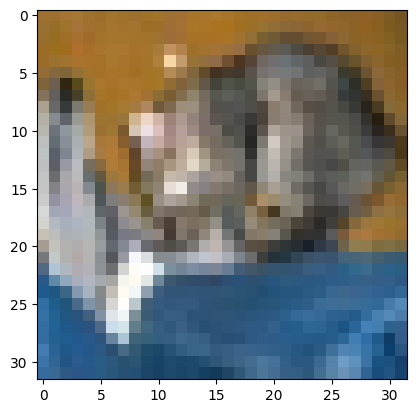

PREDICTION: 3


In [26]:
if __name__ == "__main__":
    main()